# Descripción

Llegados a este punto, vuestra tarea será replicar y emular el análisis realizado para los datos de Ámsterdam en 2018 a uno de los disponibles en [este enlace](http://insideairbnb.com/get-the-data). Para ello, se esperan los siguientes pasos:

* Obtenga mediante comandos de Linux todos los archivos precisos, teniendo en cuenta la siguiente correspondencia:
  * `listings.csv.gz`--> `listings_detailed.csv`
  * `reviews.csv.gz`--> `reviews_detailed.csv`
  * `calendar.csv.gz`--> `calendar.csv`
  * El resto tienen el mismo nombre
* Realice un estudio similar al mostrado con sus datos concretos.
* Prepare una presentación que tendrá que exponer en unos 10 minutos.

Aquí se adjunta una muestra de cómo obtener, restaurar y renombrar los tres ficheros que requieren una especial atención, usando los datos más recientes disponibles de Austin (Texas).

# 1. Importando módulos y datos

In [1]:
!pip install geopandas
!pip install chart_studio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.2 MB/s 
     |████████████████████████████████| 16.7 MB 260 kB/s 
     |████████████████████████████████| 6.3 MB 42.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 1.5 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=b83d565068613ef1c61d1cf78b9d4caf69250a740b771ed30ea73be63b16a4a7
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# mapas interactivos
import folium
from folium.plugins import FastMarkerCluster
import geopandas as gpd
from branca.colormap import LinearColormap

#to make the plotly graphs
import plotly.graph_objs as go
import chart_studio.plotly as py
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

#text mining
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud

In [3]:
# Instalamos la librería para manipular la API
! pip install -q kaggle

In [4]:
# Tras hacernos un usuario en Kaggle, vamos a la sección 'account'--> 'API'
# y seleccionamos 'Create New API Token'. Subimos aquí ese fichero.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"joseromeroextremera","key":"f5247bd4019aa89b138594124d81114e"}'}

In [5]:
!mkdir input/

!wget http://data.insideairbnb.com/greece/attica/athens/2022-03-24/data/listings.csv.gz -P input/ \
    && gunzip input/listings.csv \
    && mv input/listings.csv
!wget http://data.insideairbnb.com/greece/attica/athens/2022-03-24/data/calendar.csv.gz -P input/ \
    && gunzip input/reviews.csv \
    && mv input/reviews.csv
!wget http://data.insideairbnb.com/greece/attica/athens/2022-03-24/data/reviews.csv.gz -P input/ \
    && gunzip input/calendar.csv \
    && mv input/calendar.csv
!wget http://data.insideairbnb.com/greece/attica/athens/2022-03-24/visualisations/listings.csv -P input/ \
    && gunzip input/listings_details.csv \
    && mv input/listings_details.csv
!wget http://data.insideairbnb.com/greece/attica/athens/2022-03-24/visualisations/reviews.csv -P input/ \
    && gunzip input/reviews_details.csv \
    && mv input/reviews_details.csv
!wget http://data.insideairbnb.com/greece/attica/athens/2022-03-24/visualisations/neighbourhoods.csv -P input/ \
    && gunzip input/neighbourhoods.csv \
    && mv input/neighbourhoods.csv
!wget http://data.insideairbnb.com/greece/attica/athens/2022-03-24/visualisations/neighbourhoods.geojson -P input/ \
    && gunzip input/neighbourhoods.geojson.csv \
    && mv input/neighbourhoods.geojson.csv

--2022-06-30 17:35:39--  http://data.insideairbnb.com/greece/attica/athens/2022-03-24/data/listings.csv.gz
Resolving data.insideairbnb.com (data.insideairbnb.com)... 52.216.111.50
Connecting to data.insideairbnb.com (data.insideairbnb.com)|52.216.111.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7062047 (6.7M) [application/x-gzip]
Saving to: ‘input/listings.csv.gz’

listings.csv.gz     100%[===================>]   6.73M  25.1MB/s    in 0.3s    

2022-06-30 17:35:39 (25.1 MB/s) - ‘input/listings.csv.gz’ saved [7062047/7062047]

mv: missing destination file operand after 'input/listings.csv'
Try 'mv --help' for more information.
--2022-06-30 17:35:40--  http://data.insideairbnb.com/greece/attica/athens/2022-03-24/data/calendar.csv.gz
Resolving data.insideairbnb.com (data.insideairbnb.com)... 52.216.111.50
Connecting to data.insideairbnb.com (data.insideairbnb.com)|52.216.111.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9997651 

In [6]:
print(os.listdir("input"))

['neighbourhoods.geojson', 'calendar.csv', 'reviews.csv', 'reviews.csv.gz', 'listings.csv.1', 'listings.csv', 'neighbourhoods.csv']


In [8]:
listings = pd.read_csv("input/listings.csv", index_col= "id")
listings_details = pd.read_csv("input/listings_details.csv", index_col= "id", low_memory=False)

calendar = pd.read_csv("input/calendar.csv", parse_dates=['date'], index_col=['listing_id'])
reviews_details = pd.read_csv("input/reviews_details.csv", parse_dates=['date'])

In [9]:
print(listings.shape)

(10263, 73)


In [10]:
listings_details.columns

Index(['name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'license'],
      dtype='object')

In [42]:
listings_details.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10263 entries, 10595 to 588247781969129326
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            10259 non-null  object 
 1   host_id                         10263 non-null  int64  
 2   host_name                       10256 non-null  object 
 3   neighbourhood                   10263 non-null  object 
 4   latitude                        10263 non-null  float64
 5   longitude                       10263 non-null  float64
 6   room_type                       10263 non-null  object 
 7   price                           10263 non-null  int64  
 8   minimum_nights                  10263 non-null  int64  
 9   number_of_reviews               10263 non-null  int64  
 10  last_review                     8301 non-null   object 
 11  reviews_per_month               8301 non-null   float64
 12  calculated_host

In [11]:
listings.columns

Index(['listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_updated',

In [12]:
target_columns = ["property_type", "accommodates", "first_review", "review_scores_value", "review_scores_cleanliness", "review_scores_location", "review_scores_accuracy", "review_scores_communication", "review_scores_checkin", "maximum_nights", "listing_url", "host_is_superhost", "host_about", "host_response_time", "host_response_rate"]
listings = pd.merge(listings_details, listings[target_columns], on='id', how='outer')

In [13]:
listings_details = listings_details.drop(columns=['neighbourhood_group'])
listings['host_response_rate'] = pd.to_numeric(listings['host_response_rate'].str.strip('%'))


In [14]:
listings.head()

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,...,review_scores_location,review_scores_accuracy,review_scores_communication,review_scores_checkin,maximum_nights,listing_url,host_is_superhost,host_about,host_response_time,host_response_rate
id,,,,,,,,,,,,,,,,,,,,,
10595,"96m2, 3BR, 2BA, Metro, WI-FI etc...",37177,Emmanouil,NaN,ΑΜΠΕΛΟΚΗΠΟΙ,37.98863,23.76527,Entire home/apt,76,1,...,4.50,4.81,4.84,4.84,1125,https://www.airbnb.com/rooms/10595,t,Athens Quality Apartments is a company started...,within an hour,100.0
10990,Athens Quality Apartments - Deluxe Apartment,37177,Emmanouil,NaN,ΑΜΠΕΛΟΚΗΠΟΙ,37.98903,23.76448,Entire home/apt,50,1,...,4.83,4.86,4.92,4.91,1125,https://www.airbnb.com/rooms/10990,t,Athens Quality Apartments is a company started...,within an hour,100.0
10993,Athens Quality Apartments - Studio,37177,Emmanouil,NaN,ΑΜΠΕΛΟΚΗΠΟΙ,37.98888,23.76473,Entire home/apt,45,1,...,4.82,4.92,4.97,4.97,1125,https://www.airbnb.com/rooms/10993,t,Athens Quality Apartments is a company started...,within an hour,100.0
10995,"AQA-No2 1-bedroom, smart tv, fiber connection,",37177,Emmanouil,NaN,ΑΜΠΕΛΟΚΗΠΟΙ,37.98903,23.76448,Entire home/apt,48,1,...,4.81,4.96,4.89,4.92,1125,https://www.airbnb.com/rooms/10995,t,Athens Quality Apartments is a company started...,within an hour,100.0
27262,"54m2, 1-br, cable tv, wi-fi, metro",37177,Emmanouil,NaN,ΑΜΠΕΛΟΚΗΠΟΙ,37.98924,23.76500,Entire home/apt,69,1,...,4.69,4.81,5.00,4.94,1125,https://www.airbnb.com/rooms/27262,t,Athens Quality Apartments is a company started...,within an hour,100.0


# 2. Análisis exploratorio
2.1 Vecindario

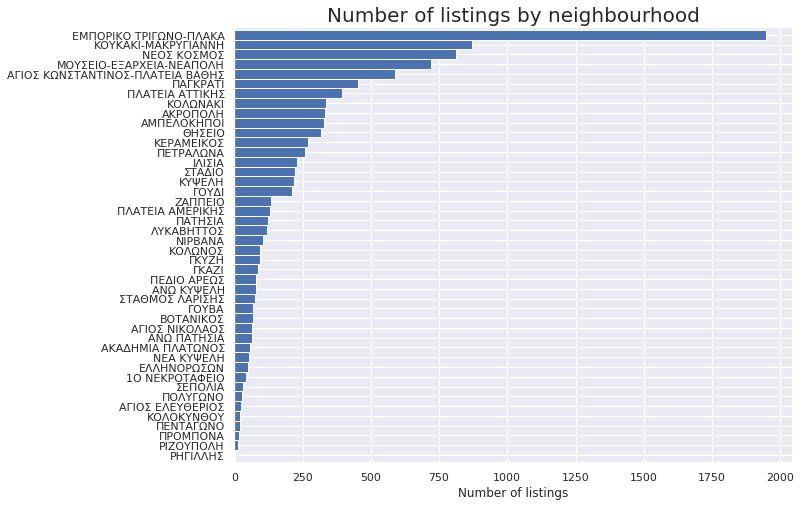

In [15]:
feq=listings['neighbourhood'].value_counts().sort_values(ascending=True)
feq.plot.barh(figsize=(10, 8), color='b', width=1)
plt.title("Number of listings by neighbourhood", fontsize=20)
plt.xlabel('Number of listings', fontsize=12)
plt.show()

In [16]:
lats2018 = listings['latitude'].tolist()
lons2018 = listings['longitude'].tolist()
locations = list(zip(lats2018, lons2018))

map1 = folium.Map(location=[37.9689, 23.7340], zoom_start=11.5)
FastMarkerCluster(data=locations).add_to(map1)
map1

## 2.2 Tipos de propiedades y habitaciones

### 2.2.1 Tipos de habitaciones

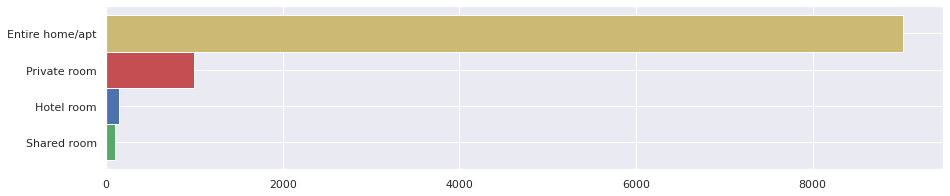

In [17]:
freq = listings['room_type']. value_counts().sort_values(ascending=True)
freq.plot.barh(figsize=(15, 3), width=1, color = ["g","b","r","y"])
plt.show()

### 2.2.2 Tipos de propiedades

En el conjunto de datos, encontramos muchos tipos de propiedades diferentes.

In [18]:
listings.property_type.unique()

array(['Entire rental unit', 'Entire loft', 'Private room in rental unit',
       'Entire residential home', 'Entire bed and breakfast',
       'Entire condominium (condo)', 'Entire villa', 'Earthen home',
       'Tiny home', 'Private room in residential home',
       'Entire guest suite', 'Private room in condominium (condo)',
       'Private room in boat', 'Entire townhouse',
       'Entire serviced apartment', 'Private room in guesthouse',
       'Private room in bed and breakfast', 'Entire guesthouse',
       'Private room in townhouse', 'Room in hotel',
       'Shared room in rental unit', 'Room in aparthotel', 'Floor',
       'Private room in hostel', 'Private room in floor',
       'Shared room in residential home', 'Room in boutique hotel',
       'Boat', 'Private room in guest suite',
       'Room in serviced apartment', 'Private room in serviced apartment',
       'Private room', 'Entire cottage', 'Entire place',
       'Shared room in guesthouse', 'Shared room in hostel', 'C

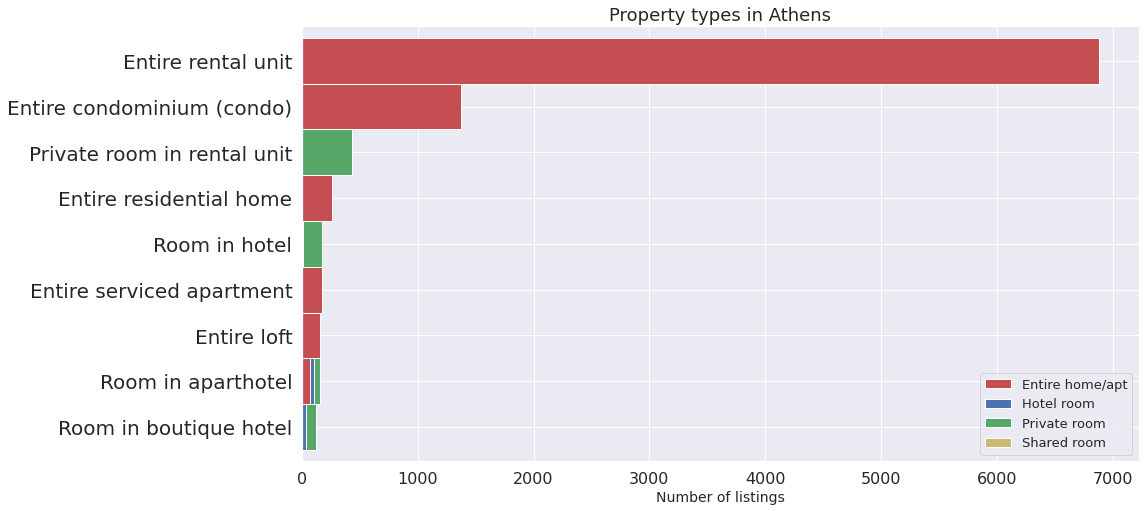

In [43]:
prop = listings.groupby(['property_type','room_type']).room_type.count()
prop = prop.unstack()
prop['total'] = prop.iloc[:,0:3].sum(axis = 1)
prop = prop.sort_values(by=['total'])
prop = prop[prop['total']>=100]
prop = prop.drop(columns=['total'])

prop.plot(kind='barh',stacked=True, color = ["r","b","g","y"],
              linewidth = 1, grid=True, figsize=(15,8), width=1)
plt.title('Property types in Athens', fontsize=18)
plt.xlabel('Number of listings', fontsize=14)
plt.ylabel("")
plt.legend(loc = 4,prop = {"size" : 13})
plt.rc('ytick', labelsize=13)
plt.show()

## 2.3 Número de alojados

Como era de esperar, la mayoría de los listados son para 2 personas. Además, Airbnb utiliza un máximo de 16 huéspedes por anuncio.

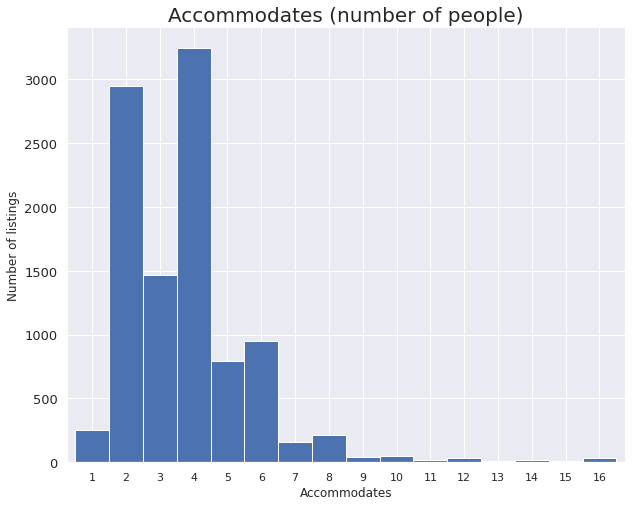

In [20]:
feq=listings['accommodates'].value_counts().sort_index()
feq.plot.bar(figsize=(10, 8), color='b', width=1, rot=0)
plt.title("Accommodates (number of people)", fontsize=20)
plt.ylabel('Number of listings', fontsize=12)
plt.xlabel('Accommodates', fontsize=12)
plt.show()

## 3.1 Encontrando potenciales hoteles ilegales

In [21]:
private = listings[listings['room_type'] == "Private room"]
host_private = private.groupby(['host_id', 'host_name']).size().reset_index(name='private_rooms').sort_values(by=['private_rooms'], ascending=False)
host_private.head()

,host_id,host_name,private_rooms
10,2089542,Tia & Mike,44
202,160981038,Nlh,20
86,40921063,Gerhard,19
224,187720552,Marianna,18
276,235598385,Sleep Easy,16


In [22]:
Nlh = private[private['host_id']== 160981038]
Nlh = Nlh[['name','host_id', 'host_name', 'latitude', 'longitude']]
Nlh.index.name = "listing_id"
Nlh

,name,host_id,host_name,latitude,longitude
listing_id,,,,,
22071303,NLH Fix | Corner Suite,160981038,Nlh,37.965250,23.72720
22071352,NLH Fix | Avenue Suite,160981038,Nlh,37.965250,23.72720
51756904,NLH Monastiraki | Standard Double Room,160981038,Nlh,37.978897,23.72657
51812178,NLH Monastiraki | Comfort Room,160981038,Nlh,37.978897,23.72657
51812645,NLH Monastiraki | Family Loft Suite,160981038,Nlh,37.978897,23.72657
51813157,NLH Monastiraki | Grand Loft Suite with Balcony,160981038,Nlh,37.978897,23.72657
51832930,NLH Monastiraki | Classic Double Room,160981038,Nlh,37.978897,23.72657
51834121,NLH Monastiraki | Deluxe Double Room with Balcony,160981038,Nlh,37.978897,23.72657
51835504,NLH Monastiraki | Superior Loft Suite with Bal...,160981038,Nlh,37.978897,23.72657


## 3.2 Efectos no deseados de los anfitriones profesionales?

In [23]:
freq = listings.groupby(['host_id']).size().reset_index(name='num_host_listings')
host_prop = freq.groupby(['num_host_listings']).size().reset_index(name='count').transpose()
host_prop.columns = host_prop.iloc[0]
host_prop = host_prop.drop(host_prop.index[0])
host_prop

num_host_listings,1,2,3,4,5,6,7,8,9,10,...,37,39,40,41,49,55,58,76,83,170
count,3763,548,215,121,79,79,33,33,26,17,...,2,1,1,1,1,1,1,1,1,1


In [24]:
freq = listings.groupby(['host_id', 'host_name', 'host_about']).size().reset_index(name='num_host_listings')
freq = freq.sort_values(by=['num_host_listings'], ascending=False)
freq = freq[freq['num_host_listings'] >= 20]
freq

,host_id,host_name,host_about,num_host_listings
631,29927830,Homm ®,Welcome to homm®\n\nThe key to success in all ...,170
89,1621474,Mint,We are the Μint team: a full service airbnb co...,83
496,20104194,Upstreet,"Hi! We are UPSTREET, a professional hosting an...",76
53,748818,George,Hi everyone!\n\nThank you for considering stay...,58
107,2089542,Tia & Mike,SINCE 2012 we have offered ACCOMMODATION with ...,55
1301,113548208,Mary,We are thrilled to welcome you to one of our A...,49
1190,90390850,Evan&Anetta,a,41
837,47038350,Golden Home Holidays,"Find your own home in Greece, for holidays or ...",40
80,1418201,D & Y Boutique Athens,We at Boutique Athens offer accommodation to t...,39
68,1167063,Dimi David Opsimoulis,"Hello everyone! I'm Dimi. I love travels, adve...",37


In [25]:
freq['host_about'][631]

'Welcome to homm®\n\nThe key to success in all our collaborations is that we undertake the complete management of your property/hotel at all stages, ensuring its perfect functionality 24/7 and providing high-end tools, aiming to increase your revenue without your participation.\n\n1. homm®️ Management\nhomm® property / hotel management services covers the needs of the modern owner / hotelier, including sales and marketing strategies, operational structure and estimation of revenue-budget.\n\n2. homm®️ Digital Sales Management\nhomm® provides the online sales management of your property / hotel, including all the major OTAs and the direct booking engine. We also analyse your competition and offer revenue and yield management, reporting and forecast, as well as the management of your reservations.\n\n3. homm®️ Digital Marketing Management\nBrand building or the rebranding of your property / hotel, homm® Marketing Services include the online and offline advertising, the construction of yo

## 4.1 Precio medio por vecindario

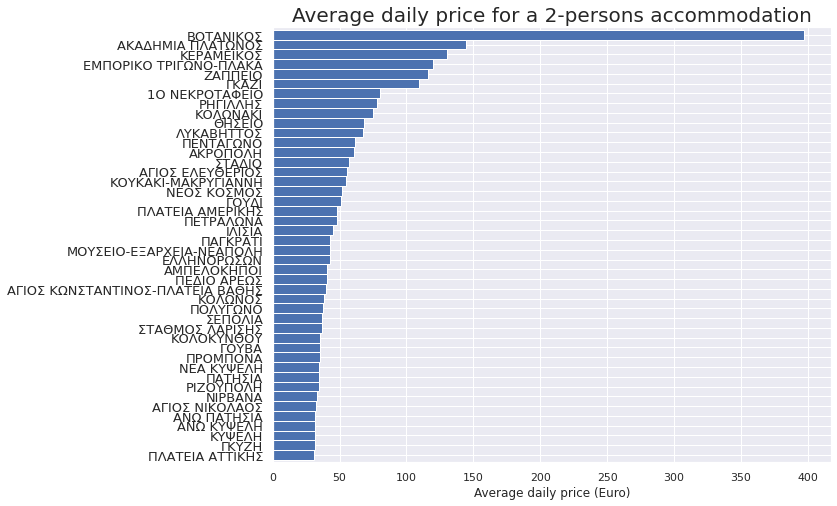

In [26]:
feq = listings[listings['accommodates']==2]
feq = feq.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)
feq.plot.barh(figsize=(10, 8), color='b', width=1)
plt.title("Average daily price for a 2-persons accommodation", fontsize=20)
plt.xlabel('Average daily price (Euro)', fontsize=12)
plt.ylabel("")
plt.show()

A continuación puede encontrar los barrios en un mapa. Este mapa es **interactivo**. Al pasar el cursor sobre los polígonos se muestra el nombre del barrio y el precio medio de los alojamientos para 2 personas.

In [27]:
adam = gpd.read_file("input/neighbourhoods.geojson")
feq = pd.DataFrame([feq])
feq = feq.transpose()
adam = pd.merge(adam, feq, on='neighbourhood', how='left')
adam.rename(columns={'price': 'average_price'}, inplace=True)
adam.average_price = adam.average_price.round(decimals=0)

In [53]:
map_dict = adam.set_index('neighbourhood')['average_price'].to_dict()
color_scale = LinearColormap(['yellow','red'], vmin = min(map_dict.values()), vmax = max(map_dict.values()))

def get_color(feature):
    value = map_dict.get(feature['properties']['neighbourhood'])
    return color_scale(value)

map3 = folium.Map(location=[37.9689, 23.7340], zoom_start=11)
folium.GeoJson(data=adam,
               name='Athens',
               tooltip=folium.features.GeoJsonTooltip(fields=['neighbourhood', 'average_price'],
                                                      labels=True,
                                                      sticky=False),
               style_function= lambda feature: {
                   'fillColor': get_color(feature),
                   'color': 'black',
                   'weight': 1,
                   'dashArray': '5, 5',
                   'fillOpacity':0.5
                   },
               highlight_function=lambda feature: {'weight':3, 'fillColor': get_color(feature), 'fillOpacity': 0.8}).add_to(map3)
map3

ValueError: ignored

## 4.2 Seguridad del vecindario

## 4.3 Review scores location, and location scores versus price

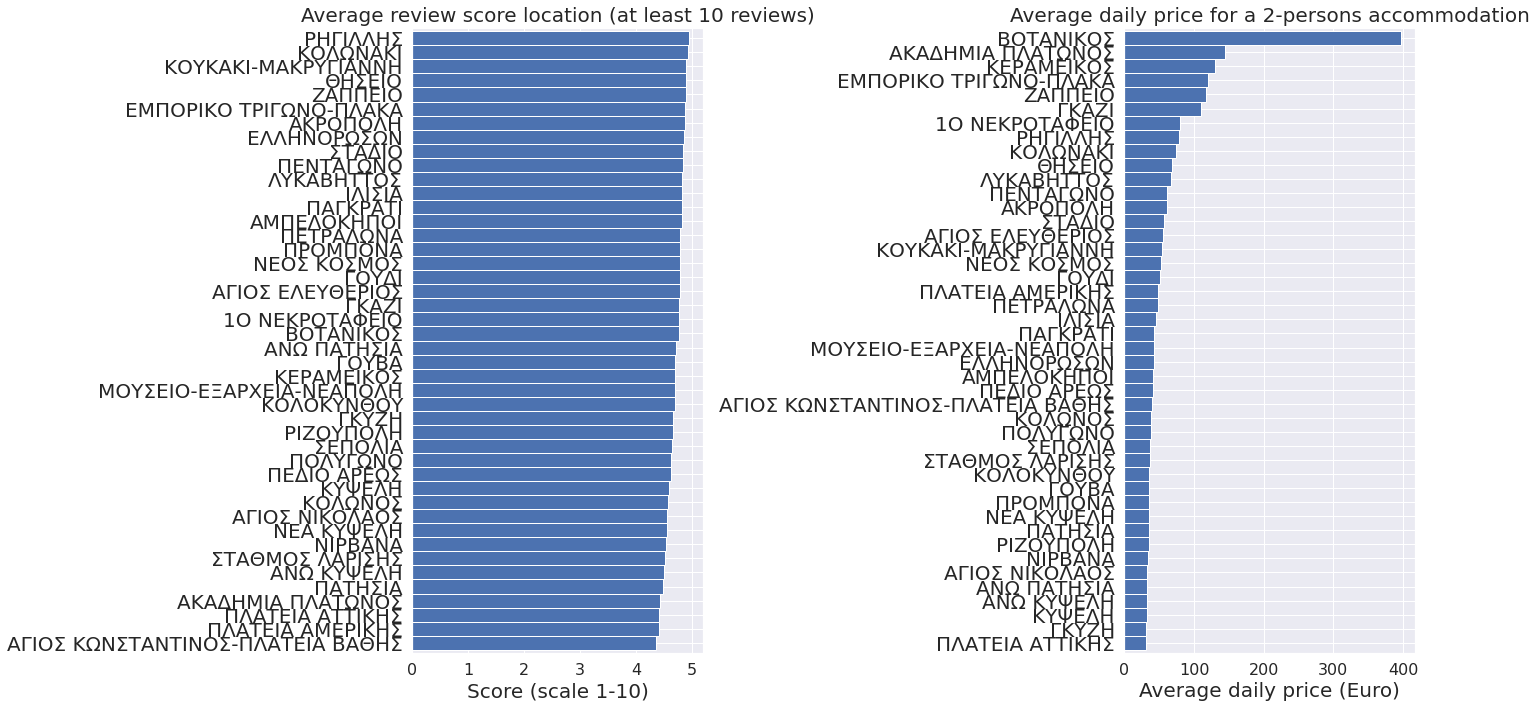

In [29]:
fig = plt.figure(figsize=(20,10))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=20)

ax1 = fig.add_subplot(121)
feq = listings[listings['number_of_reviews']>=10]
feq1 = feq.groupby('neighbourhood')['review_scores_location'].mean().sort_values(ascending=True)
ax1=feq1.plot.barh(color='b', width=1)
plt.title("Average review score location (at least 10 reviews)", fontsize=20)
plt.xlabel('Score (scale 1-10)', fontsize=20)
plt.ylabel("")

ax2 = fig.add_subplot(122)
feq = listings[listings['accommodates']==2]
feq2 = feq.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)
ax2=feq2.plot.barh(color='b', width=1)
plt.title("Average daily price for a 2-persons accommodation", fontsize=20)
plt.xlabel('Average daily price (Euro)', fontsize=20)
plt.ylabel("")

plt.tight_layout()
plt.show()

## 4.4 Cómo usar las puntuaciones de las opiniones

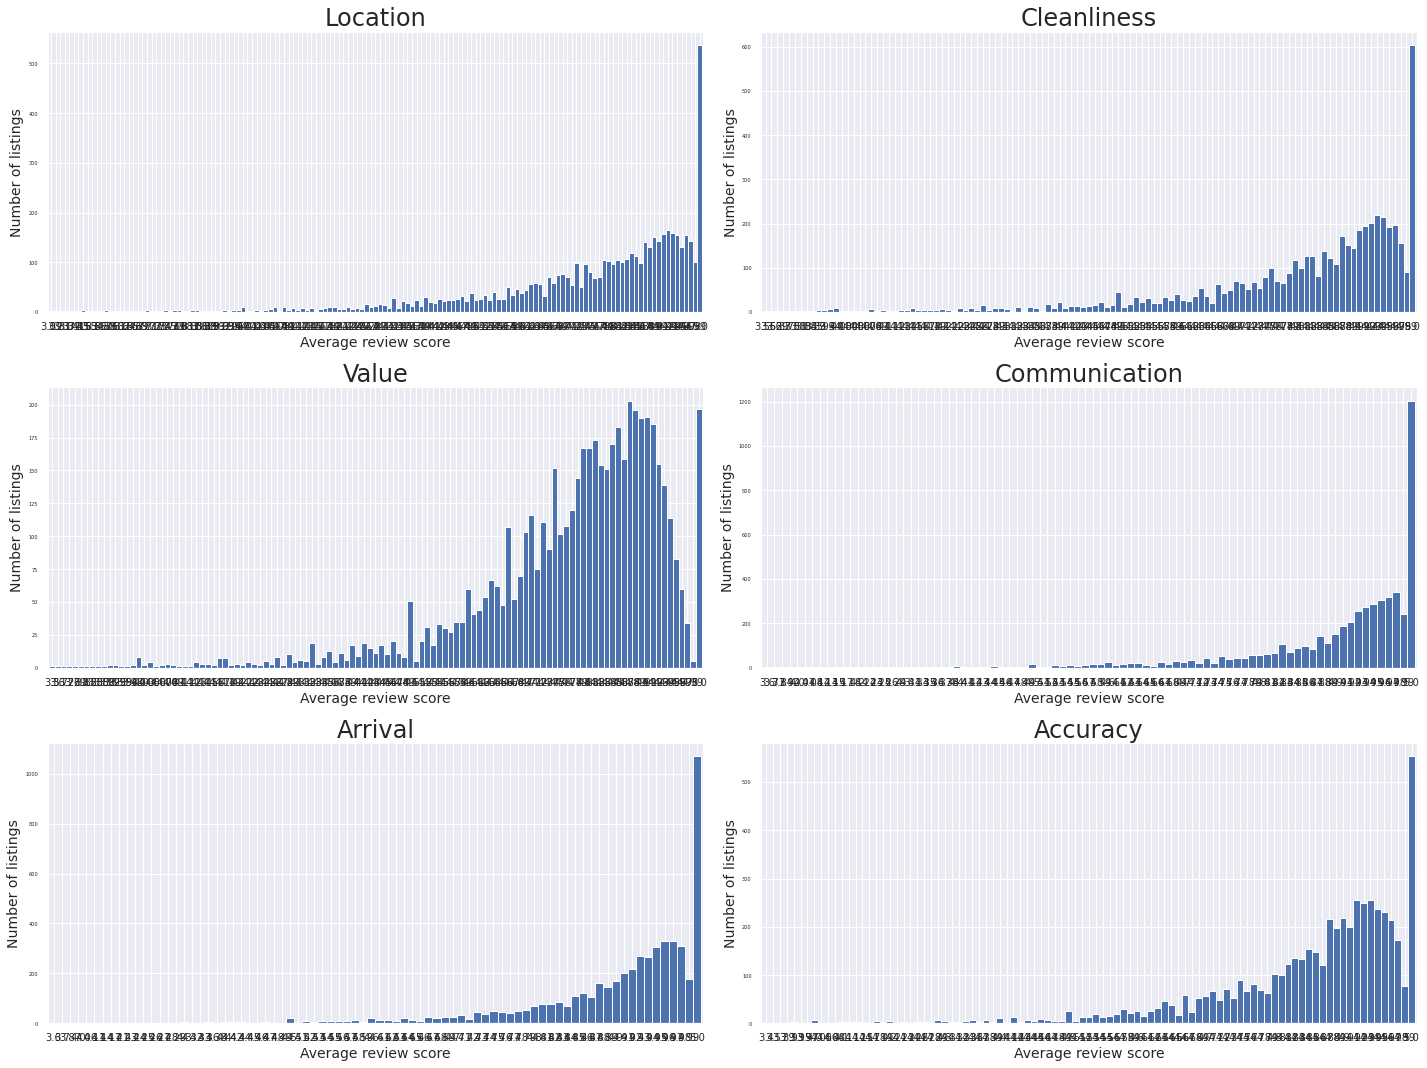

In [30]:
listings10 = listings[listings['number_of_reviews']>=10]

fig = plt.figure(figsize=(20,15))
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=5)

ax1 = fig.add_subplot(321)
feq=listings10['review_scores_location'].value_counts().sort_index()
ax1=feq.plot.bar(color='b', width=1, rot=0)
#ax1.tick_params(axis = 'both', labelsize = 16)
plt.title("Location", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax2 = fig.add_subplot(322)
feq=listings10['review_scores_cleanliness'].value_counts().sort_index()
ax2=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Cleanliness", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax3 = fig.add_subplot(323)
feq=listings10['review_scores_value'].value_counts().sort_index()
ax3=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Value", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax4 = fig.add_subplot(324)
feq=listings10['review_scores_communication'].value_counts().sort_index()
ax4=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Communication", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax5 = fig.add_subplot(325)
feq=listings10['review_scores_checkin'].value_counts().sort_index()
ax5=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Arrival", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax6 = fig.add_subplot(326)
feq=listings10['review_scores_accuracy'].value_counts().sort_index()
ax6=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Accuracy", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

plt.tight_layout()
plt.show()

## 4.5 Encontrando un buen hospedador

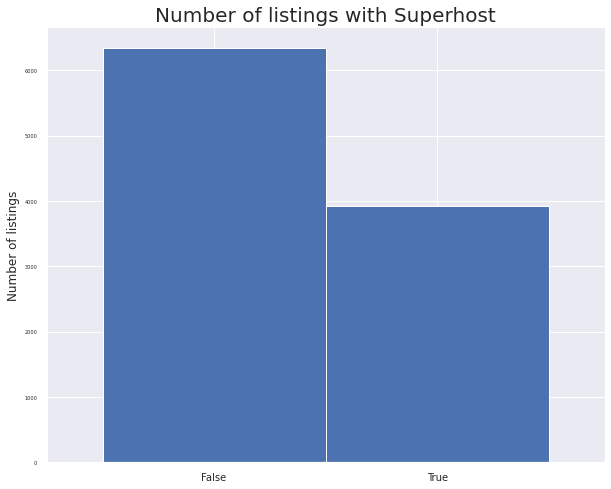

In [31]:
listings.host_is_superhost = listings.host_is_superhost.replace({"t": "True", "f": "False"})

feq=listings['host_is_superhost'].value_counts()
feq.plot.bar(figsize=(10, 8), width=1, rot=0)
plt.title("Number of listings with Superhost", fontsize=20)
plt.ylabel('Number of listings', fontsize=12)
plt.show()

Si tuviéramos que reservar alojamiento, no buscaríamos necesariamente un superhost. En realidad, me temo que pagaría demasiado, ya que el superhost probablemente aumentará sus precios. Sin embargo, tampoco me gustaría un host que responde mal o cancela mucho.

Como podemos ver, más de 4.000 de los 6.000 listados tienen al menos 10 reseñas y responden al menos al 90% de los mensajes nuevos. Consideraría que esos anfitriones son buenos respondedores "probados" (lo que no significa que una lista con menos de 10 reseñas no pueda tener buenos anfitriones que respondan; simplemente no está probado todavía). Además, hay muy pocos listados con anfitriones que no respondan a los mensajes nuevos dentro de las 24 horas.

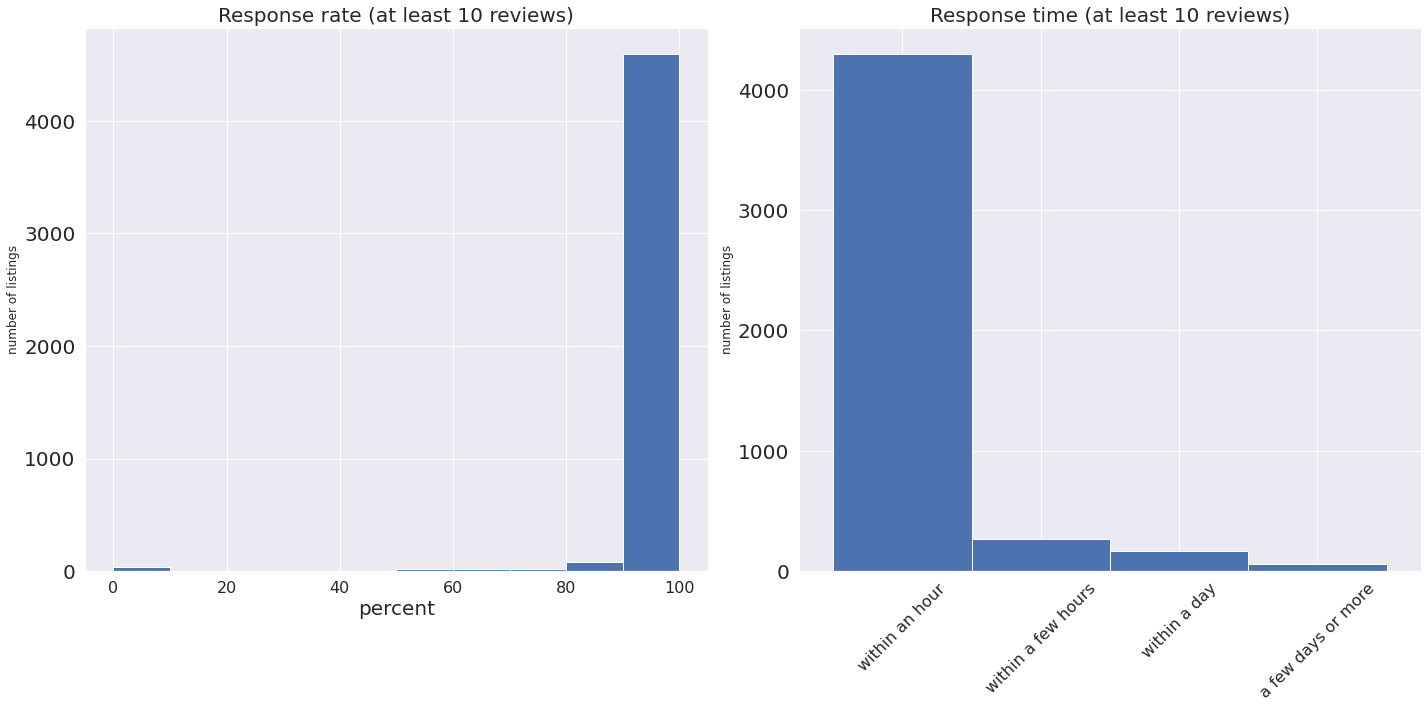

In [32]:
fig = plt.figure(figsize=(20,10))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=20)

ax1 = fig.add_subplot(121)
feq1 = listings10['host_response_rate'].dropna()
ax1= plt.hist(feq1)
plt.title("Response rate (at least 10 reviews)", fontsize=20)
plt.ylabel("number of listings")
plt.xlabel("percent", fontsize=20)

ax2 = fig.add_subplot(122)
feq2 = listings10['host_response_time'].value_counts()
ax2=feq2.plot.bar(color='b', width=1, rot=45)
plt.title("Response time (at least 10 reviews)", fontsize=20)
plt.ylabel("number of listings")

plt.tight_layout()
plt.show()

## 4.6 Disponibilidad en el tiempo

---



El archivo de calendario contiene 365 registros para cada listado, lo que significa que para cada listado, el precio y la disponibilidad por fecha se especifican con 365 días de anticipación.

In [33]:
calendar.price = calendar.price.str.replace(",","")
calendar['price'] = pd.to_numeric(calendar['price'].str.strip('$'))
calendar = calendar[calendar.date < '2022-12-05']

In [34]:
print(calendar.shape)

(2627328, 6)


A continuación se muestra un ejemplo de los datos del calendario. Importante tener en cuenta: la disponibilidad es FALSE significa que el propietario no quiere alquilar su propiedad en la fecha específica o que la lista ya se ha reservado para esa fecha. Como queremos comparar manzanas con manzanas nuevamente con respecto a los precios en la siguiente sección, estamos fusionando la variable 'accomodate' con el calendario.

In [35]:
listings.index.name = "listing_id"
calendar = pd.merge(calendar, listings[['accommodates']], on = "listing_id", how = "left")
calendar.sample(15)

,date,available,price,adjusted_price,minimum_nights,maximum_nights,accommodates
listing_id,,,,,,,
49139306,2022-07-17,t,30.0,$30.00,3,1125,4
37777286,2022-05-20,t,100.0,$100.00,1,30,3
26179128,2022-10-28,t,62.0,$53.00,3,1125,4
53354110,2022-05-02,f,250.0,$250.00,3,1125,3
8788848,2022-06-03,f,32.0,$32.00,2,1125,2
23056291,2022-08-05,t,38.0,$38.00,1,1125,2
27465507,2022-10-28,t,19.0,$19.00,30,1125,2
23736988,2022-08-05,t,30.0,$30.00,2,1125,4
39272093,2022-06-24,t,38.0,$38.00,2,1125,2


Este gráfico es **interactivo** y, al pasar el cursor sobre los puntos, se mostrará una información sobre herramientas con el "número de listados disponibles" y el "día de la semana" por fecha.

In [36]:
import plotly.io as pio
pio.renderers.default = "colab"

In [37]:
sum_available = calendar[calendar.available == "t"].groupby(['date']).size().to_frame(name= 'available').reset_index()
sum_available['weekday'] = sum_available['date'].dt.day_name()
sum_available = sum_available.set_index('date')

sum_available.iplot(y='available', mode = 'lines', xTitle = 'Date', yTitle = 'number of listings available',\
                   text='weekday', title = 'Number of listings available by date')

## 4.7 Precio medio por día

In [38]:
average_price = calendar[(calendar.available == "t") & (calendar.accommodates == 2)].groupby(['date']).mean().astype(np.int64).reset_index()
average_price['weekday'] = average_price['date'].dt.day_name()
average_price = average_price.set_index('date')

average_price.iplot(y='price', mode='lines', xTitle='Date', yTitle='Price',
    text='weekday', title='Average price of available 2 persons accommodation by date')

# 5. Minería de texto con las _reviews_ (opcional)

In [39]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [40]:
reviews_details.shape

(432988, 2)

In [41]:
reviews_details = pd.merge(reviews_details, listings[['host_id', 'host_name', 'name']], on = "listing_id", how = "left")
reviews_details = reviews_details.set_index('id')
reviews_details = reviews_details[['listing_id', 'name', 'host_id', 'host_name', 'date', 'reviewer_id', 'reviewer_name', 'comments']]
reviews_details.head()

KeyError: ignored

In [ ]:
host_reviews = reviews_details.groupby(['host_id', 'host_name']).size().sort_values(ascending=False).to_frame(name = "number_of_reviews")
host_reviews.head()

In [ ]:
reviews_details.comments.head()

In [ ]:
reviews_details.comments.values[2] #print comment with numbers and windows line break

In [ ]:
#take out empty comments (530)
reviews_details = reviews_details[reviews_details['comments'].notnull()]

#remove numbers
reviews_details['comments'] = reviews_details['comments'].str.replace('\d+', '') 
#all to lowercase
reviews_details['comments'] = reviews_details['comments'].str.lower()
#remove windows new line
reviews_details['comments'] = reviews_details['comments'].str.replace('\r\n', "")
#remove stopwords (from nltk library)
stop_english = stopwords.words("english")
reviews_details['comments'] = reviews_details['comments'].apply(lambda x: " ".join([i for i in x.split() 
                                                      if i not in (stop_english)]))
# remove punctuation
reviews_details['comments'] = reviews_details['comments'].str.replace('[^\w\s]'," ")
# replace x spaces by one space
reviews_details['comments'] = reviews_details['comments'].str.replace('\s+', ' ')

reviews_details.comments.values[2] #print same comments again

Veamos cómo implementar un conteo de palabras y emplearlo para crear un *wordcloud*

In [ ]:
texts = reviews_details.comments.tolist()

vec = CountVectorizer().fit(texts)
bag_of_words = vec.transform(texts)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

cvec_df = pd.DataFrame.from_records(words_freq, columns= ['words', 'counts']).sort_values(by="counts", ascending=False)
cvec_df.head(10)

In [ ]:
cvec_dict = dict(zip(cvec_df.words, cvec_df.counts))

wordcloud = WordCloud(width=800, height=400)
wordcloud.generate_from_frequencies(frequencies=cvec_dict)
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()